In [1]:
!pip install -Uqq fastbook
from itertools import islice
import gzip

import fastbook
fastbook.setup_book()

In [2]:
from fastai.text.core import WordTokenizer, Tokenizer
from fastai.text.learner import TextLearner
from fastbook import *

In [3]:
def get_dls(limit, bs, sl):
    path = download_data("https://github.com/tianhuil/number-generator/blob/main/data/en.txt.gz?raw=true")
    with gzip.open(path, 'rt') as fh:
        lines = L([line.strip() for line in islice(fh, 1, limit+1)])
    text = ' . '.join([l.strip() for l in lines])
    text = text.replace(', ', ' , ').replace('-', ' - ')
    tokens = text.split(' ')
    vocab = L(tokens).unique()
    word2idx = {w:i for i,w in enumerate(vocab)}
    nums = L(word2idx[i] for i in tokens)

    def group_chunks(ds, bs):
        m = len(ds) // bs
        new_ds = L()
        for i in range(m): new_ds += L(ds[i + m*j] for j in range(bs))
        return new_ds

    seqs = L((tensor(nums[i:i+sl]), tensor(nums[i+1:i+sl+1]))
             for i in range(0,len(nums)-sl-1,sl))

    cut = int(len(seqs) * 0.8)
    dls = DataLoaders.from_dsets(group_chunks(seqs[:cut], bs),
                                 group_chunks(seqs[cut:], bs),
                                 bs=bs, drop_last=True, shuffle=False)
    return dls, len(vocab)

In [4]:
class LMModel7(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(out),raw,out
    
    def reset(self): 
        for h in self.h: h.zero_()
            

In [5]:
limit = 10000
sl = 16
df_results = []

for bs in (16, 32, 64, 128):
    dls, vocab_sz = get_dls(limit, bs, sl)

    model = LMModel7(vocab_sz, bs, 2, 0.4)

    # learn = Learner(dls, model,
    #                 loss_func=CrossEntropyLossFlat(), metrics=accuracy,
    #                 cbs=[ModelResetter, RNNRegularizer(alpha=2, beta=1)])

    learn = TextLearner(dls, model,
                        loss_func=CrossEntropyLossFlat(), metrics=accuracy)

    df = learn.fit_one_cycle(15, 1e-2, wd=0.1)

    df_results.append(pd.DataFrame(
        [[k] + vals for [k, vals] in enumerate(learn.recorder.values)],
        columns=learn.recorder.metric_names[:-1]
    ))
    df_results[-1]['bs'] = bs
    
df_result = pd.concat(df_results)

epoch,train_loss,valid_loss,accuracy,time
0,2.102424,1.572288,0.581227,00:06
1,1.142126,1.161230,0.624483,00:06
2,1.011857,1.172876,0.625230,00:06
3,0.986465,1.220499,0.624426,00:06
4,0.978392,1.232291,0.624368,00:06
5,0.938813,1.238118,0.625517,00:06
6,0.919525,1.182205,0.628159,00:06
7,0.927597,1.188122,0.626723,00:06
8,0.863779,1.160848,0.630342,00:06
9,0.818168,1.131316,0.637580,00:06


epoch,train_loss,valid_loss,accuracy,time
0,2.091334,1.512601,0.603516,00:03
1,1.160042,1.147326,0.651080,00:03
2,0.780617,1.196660,0.649472,00:04
3,0.554637,1.259672,0.643267,00:03
4,0.443060,0.926714,0.727711,00:03
5,0.394329,0.664696,0.796875,00:03
6,0.319286,0.551074,0.823874,00:03
7,0.261830,0.635723,0.837948,00:03
8,0.204622,0.344367,0.886719,00:03
9,0.168980,0.348351,0.873104,00:03


epoch,train_loss,valid_loss,accuracy,time
0,2.034735,1.356347,0.583353,00:02
1,1.253617,1.185823,0.623277,00:02
2,0.766272,1.101241,0.691808,00:02
3,0.360718,0.861703,0.813706,00:02
4,0.161656,0.665460,0.829676,00:02
5,0.079225,0.745212,0.836857,00:02
6,0.044393,0.649147,0.866958,00:02
7,0.030464,0.510324,0.874311,00:02
8,0.023728,0.503646,0.879940,00:02
9,0.018626,0.511298,0.882353,00:02


epoch,train_loss,valid_loss,accuracy,time
0,2.103811,1.424448,0.562866,00:02
1,1.416044,1.258659,0.630066,00:02
2,0.978713,1.147913,0.736816,00:02
3,0.577295,1.117853,0.838257,00:02
4,0.339236,0.835990,0.861206,00:02
5,0.189261,0.909378,0.865295,00:03
6,0.110116,1.029570,0.866150,00:03
7,0.069998,1.112282,0.860046,00:03
8,0.047281,1.027689,0.868774,00:02
9,0.035389,0.954974,0.869507,00:02


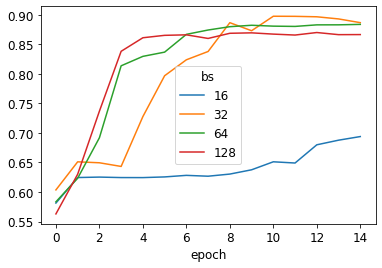

In [6]:
df_result.pivot(index='epoch', columns='bs', values='accuracy').plot();